In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

In [2]:
!make -j4
!./gzip  -c -s 98304 ~/data/frag_1.fastq.gz 2>/dev/null 1>|/tmp/backrefs

In [3]:
chars = []
for l in open('/tmp/backrefs'):
    if l[0] == 'b':
        chars.append(int(l[1:-1]))
    elif l[0] == 'c':
        chars.append(l[1:2])
    else:
        print('bad output line %r' % l)

In [4]:
wsize = 1<<15
last_seen = np.zeros(wsize)
is_backref = np.zeros(len(chars), dtype=np.uint16)
for i,bref in enumerate(chars):
    if(type(bref) is int):
        is_backref[i] = 1
        last_seen[wsize - bref] = i
            

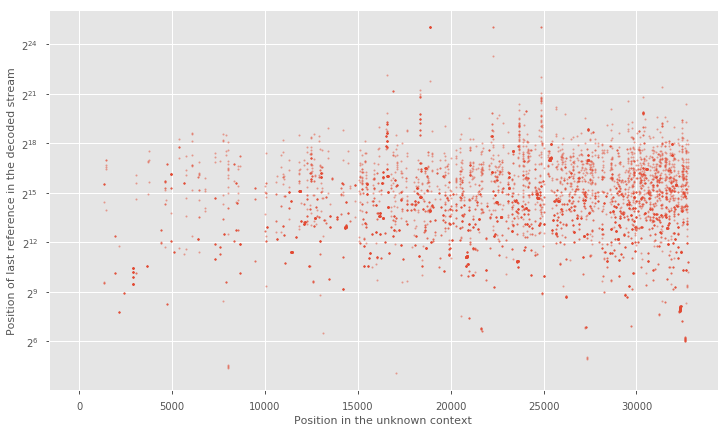

In [5]:
plt.figure(figsize=(12,7))
plt.plot(np.arange(wsize), last_seen, 'o', alpha=0.5, markeredgecolor='none', markersize=2);
plt.yscale('log', basey=2)
plt.xlabel('Position in the unknown context')
plt.ylabel('Position of last reference in the decoded stream');

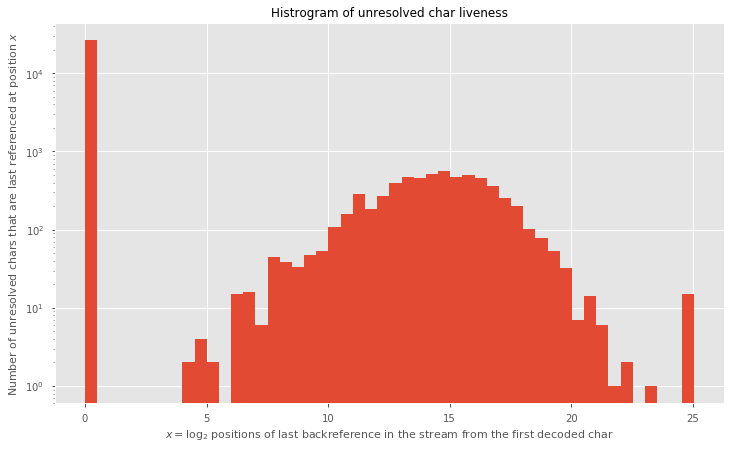

In [6]:
plt.figure(figsize=(12,7))
plt.hist(np.log2(last_seen+1), 50, log=True);
plt.title('Histrogram of unresolved char liveness')
plt.xlabel('$x=\log_2$ positions of last backreference in the stream from the first decoded char')
plt.ylabel('Number of unresolved chars that are last referenced at position $x$');

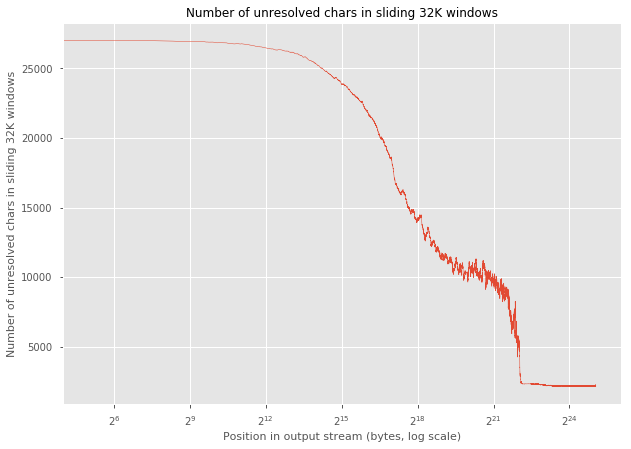

In [7]:
# First decimate is_backref by a factor of 32
# ie we count the number of backrefs for each 64char non overlapping window

unresolved_inwin = is_backref.copy()
decimate_power = 5
decimate_factor = 1
for i in range(decimate_power):
    unresolved_inwin = unresolved_inwin[:len(unresolved_inwin) & ~1]
    unresolved_inwin = unresolved_inwin[1::2] + unresolved_inwin[0::2]
    decimate_factor *= 2

# count bacrefs in sliding window of 32k:
unresolved_inwin = np.convolve(unresolved_inwin,np.ones(wsize//decimate_factor,dtype=np.uint16), 'valid')

plt.figure(figsize=(10,7))
xaxis = np.arange(len(unresolved_inwin)) * decimate_factor
plt.plot(xaxis, unresolved_inwin, linewidth=0.5);
plt.xscale('log', basex=2)
plt.xlabel('Position in output stream (bytes, log scale)')
plt.ylabel('Number of unresolved chars in sliding 32K windows');
plt.title('Number of unresolved chars in sliding 32K windows');

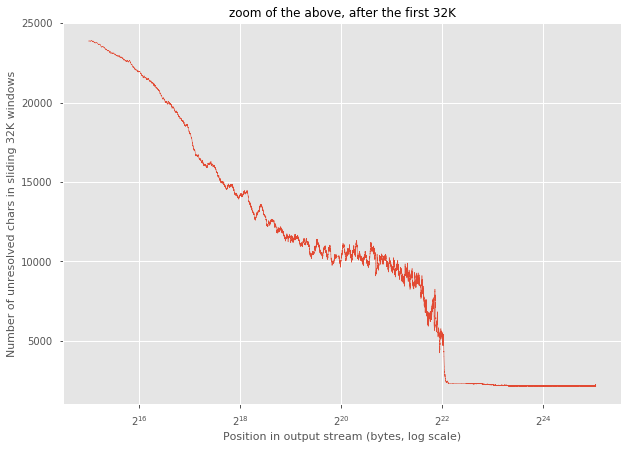

In [8]:
plt.figure(figsize=(10,7))
skip = 1<<(15-decimate_power)
plt.plot(xaxis[skip:], unresolved_inwin[skip:], linewidth=0.5);
plt.xscale('log', basex=2)
plt.xlabel('Position in output stream (bytes, log scale)')
plt.ylabel('Number of unresolved chars in sliding 32K windows');
plt.title('zoom of the above, after the first 32K');

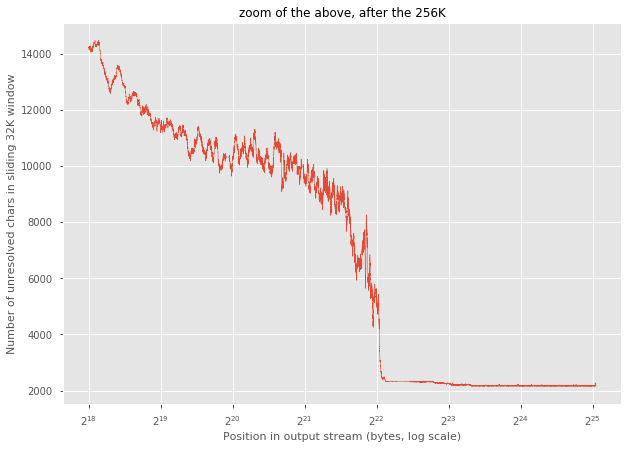

In [9]:
plt.figure(figsize=(10,7))
skip = 8<<(15-decimate_power)
plt.plot(xaxis[skip:], unresolved_inwin[skip:], linewidth=0.5);
plt.xscale('log', basex=2)
plt.xlabel('Position in output stream (bytes, log scale)')
plt.ylabel('Number of unresolved chars in sliding 32K window');
plt.title('zoom of the above, after the 256K');

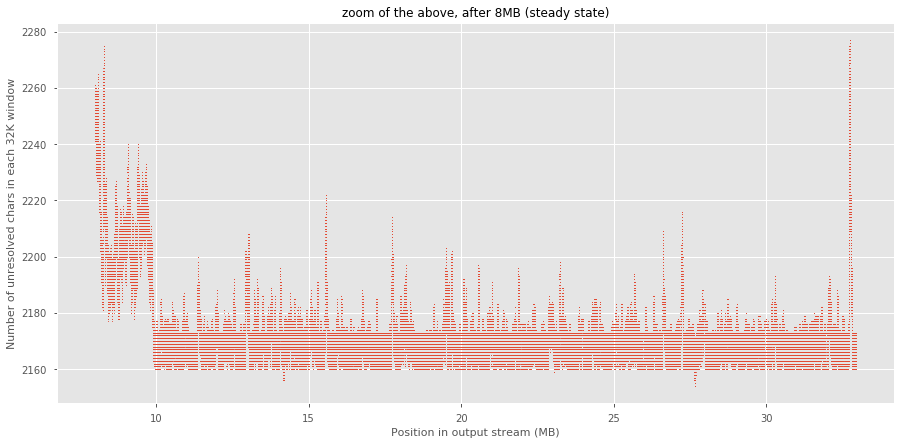

In [10]:
plt.figure(figsize=(15,7))
skip = (8<<20)//decimate_factor
plt.plot(xaxis[skip:]/(1<<20), unresolved_inwin[skip:], 'o', linewidth=0.2, markersize=1);
plt.xlabel('Position in output stream (MB)')
plt.ylabel('Number of unresolved chars in each 32K window');
plt.title('zoom of the above, after 8MB (steady state)');